<a href="https://colab.research.google.com/github/ShauryaBhardwaj/CSF425/blob/main/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

# Machine Learning Models

## Linear Models
## 1. Regression
### 2. Classification

###*Loading data*


Method to load dataset onto google colab for use

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


Arranging file system and downloading dataset on linux system

In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/
!kaggle datasets download -d dgawlik/nyse
!unzip nyse.zip

 91% 28.0M/30.7M [00:00<00:00, 30.8MB/s]
100% 30.7M/30.7M [00:00<00:00, 88.1MB/s]
Archive:  nyse.zip
  inflating: fundamentals.csv        
  inflating: prices-split-adjusted.csv  
  inflating: prices.csv              
  inflating: securities.csv          


To see file structure on the linux machine

In [ ]:
!ls

fundamentals.csv  prices.csv		     sample_data
nyse.zip	  prices-split-adjusted.csv  securities.csv


###*Preprocess data*

Loading data into tabular form using a Python library called Pandas

In [ ]:
import pandas as pd
dataframe = pd.read_csv('prices-split-adjusted.csv' , parse_dates=['date']) # parse_dates converts dates in string format to Time-stamp format.
dataframe.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


Selecting Google stocks from the entire Dataframe

In [ ]:
google_df = dataframe[dataframe['symbol']=='GOOG'].set_index('date')
google_df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,GOOG,312.304948,312.205308,310.955001,313.580158,3927000.0
2010-01-05,GOOG,312.419511,310.830459,309.610028,312.748278,6031900.0
2010-01-06,GOOG,311.761979,302.994813,302.048370,311.761979,7987100.0
2010-01-07,GOOG,303.562685,295.941242,295.218951,303.861575,12876600.0
2010-01-08,GOOG,294.895159,299.886470,293.455551,300.499172,9483900.0


Matplotlib is used to observe the nature of the data

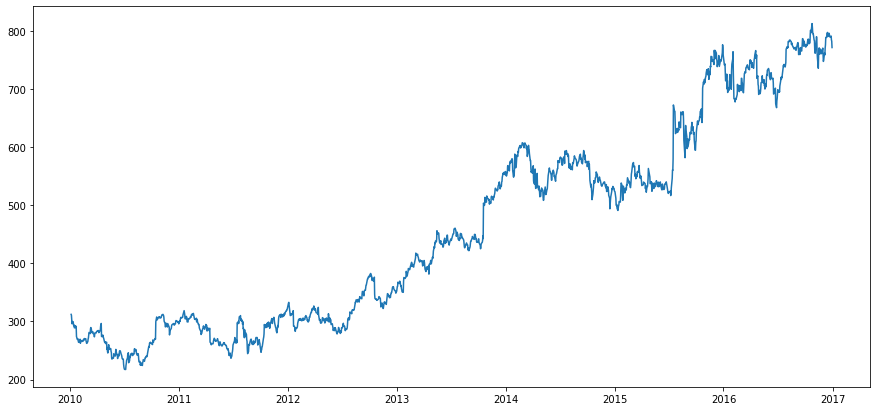

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(google_df.close)

Converts absolute dates to dates relative to the first day

In [ ]:
first_day = google_df.index.min()
def calculate_day_since(date, reference=first_day): return (date-reference).days
x=list(map(calculate_day_since,google_df.index))
x[:10]

[0, 1, 2, 3, 4, 7, 8, 9, 10, 11]

Using the 'close' column as the output variable to be predicted. Converting it into a list.

In [ ]:
y=list(google_df.close)
y[:10]

[312.20530835799997,
 310.830458632,
 302.994812557,
 295.941242071,
 299.88646988799997,
 299.433161001,
 294.138016503,
 292.449323638,
 293.824173364,
 288.917548598]

Viewing and verifying our data

Text(0.5, 0, 'Days since 4 Jan 2010')

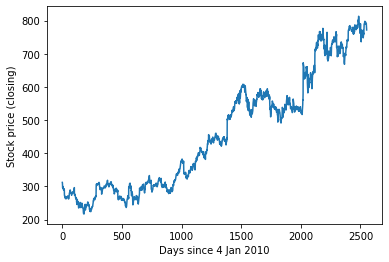

In [ ]:
assert len(x)==len(y) 
plt.plot(x,y)
plt.ylabel('Stock price (closing)')
plt.xlabel('Days since 4 Jan 2010')

In [ ]:
modified_x = [[i] for i in x] #converting x to a format accepted by LinearRegression model given in sklearn
modified_x[:10]

[[0], [1], [2], [3], [4], [7], [8], [9], [10], [11]]

##Creating and training the model.

### 1. Using Sklearn library

In [ ]:
from sklearn.linear_model import LinearRegression
reg=LinearRegression().fit(modified_x,y) # LinearRegression() creates a model and fit() function fits the model to the given data
w,b = reg.coef_, reg.intercept_ # The calculated parameters of the line are extracted in variables w and b

def lin_model(x): return x*w + b # by doing this we can simply do lin_model(x0) to find the prediction at day number x0
re

In [ ]:
print(w , b)

[0.22513196] 172.36461228620266


Plotting and verifying our model

Text(0.5, 0, 'Days since 4 Jan 2010')

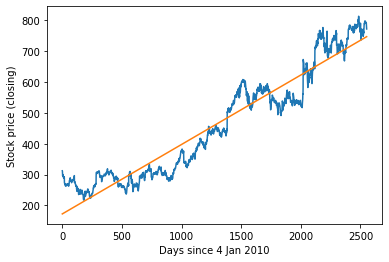

In [ ]:
plt.plot(x,y) # original data
plt.plot(x,[lin_model(o) for o in x]) # predicted line
plt.ylabel('Stock price (closing)') 
plt.xlabel('Days since 4 Jan 2010')

### 2. Using Pytorch

Convert data in list form to Tensor form

In [ ]:
x_tensor, y_tensor = torch.tensor(x).float(), torch.tensor(y).float()
x_tensor.shape, y_tensor.shape
x_max = x_tensor.max()
x_tensor = x_tensor/x_max
x_tensor

tensor([0.0000e+00, 3.9185e-04, 7.8370e-04,  ..., 9.9922e-01, 9.9961e-01,
        1.0000e+00])

Defining the loss function

In [ ]:
loss_fn = torch.nn.MSELoss()

def loss_LinearRegression(pred,target):
    assert len(pred)==len(target)
    return loss_fn(pred,target)

Creating a function called model that takes x and parameters(w,b) as inputs and returns w*x + b. 

And a function to perform one iteration of gradient descent

In [ ]:
params = torch.tensor([0.,10.]).requires_grad_() # initialising parameters | requires_grads_() associates gradients with these parameters that will be used for gradient descent.

def model(x,params=params):
    w,b = params
    return w*x + b

def train_one_iteration(params,lr=1e-4):
    #step 1: calculate predictions
    preds = model(x_tensor,params)
    # calculate loss between preds and actual y's
    loss= loss_LinearRegression(preds,y_tensor)
    #calculate gradients
    loss.backward()
    #update variables through the gradient descent equation
    params.data-=lr*params.grad.data
    #print('MSE Loss: ', loss_LinearRegression(preds,y_tensor).item())
    #print('w: '+ str(params.data[0]) + ', b: ' + str(params.data[1]))
    params.grad=None

Checking the predictions before training the model

MSE Loss:  232395.9375


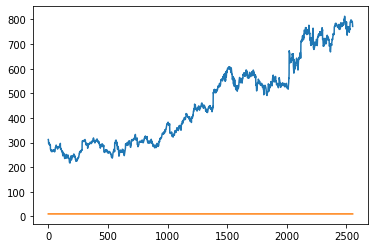

In [ ]:
def plot_linreg_model(params):
    plt.plot(x_tensor*x_max,y_tensor)
    pred=model(x_tensor,params).detach() # .detach is very important
    plt.plot(x_tensor*x_max,pred)
    print('MSE Loss: ', loss_LinearRegression(pred,y_tensor).item())

plot_linreg_model(params) 

Training the model using a for loop and the function train_one_iteration

MSE Loss:  3034.147216796875


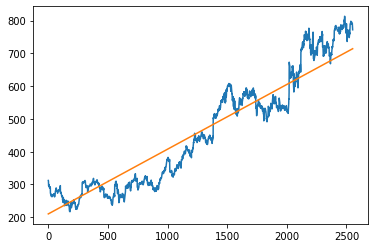

In [ ]:
for _ in range(50):
  train_one_iteration(params,lr=0.25)
plot_linreg_model(params)

## Deployment using Gradio

In [ ]:
!pip install gradio

In [ ]:
def stock_prediction(day):
  w,b = params
  d = torch.tensor(day/x_max)
  return (w*d + b).item()

In [ ]:
import gradio as gr

iface = gr.Interface(fn=stock_prediction, inputs="number", outputs="number")
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://36192.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f2cd5b4a2d0>,
 'http://127.0.0.1:7861/',
 'https://36192.gradio.app')

## Classification

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/
!mkdir titanic
%cd titanic
!kaggle competitions download -c titanic

/content/titanic
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 43.9MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 10.6MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.06MB/s]


In [ ]:
!ls

gender_submission.csv  test.csv  train.csv


### Loading data

In [ ]:
import pandas as pd
import numpy as np
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
g_sub = pd.read_csv('gender_submission.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
print(train_df.shape , test_df.shape)

(891, 12) (418, 11)


In [ ]:
from pandas.core.internals.managers import T
train_df['Embarked'].replace({'S':0 , 'C': 1 , 'Q': 2 , np.nan : 3} , inplace=True)
test_df['Embarked'].replace({'S':0 , 'C': 1 , 'Q': 2 , np.nan : 3} , inplace=True)

train_df['Sex'].replace({'male': 0 ,'female':1} , inplace=True)
test_df['Sex'].replace({'male': 0 ,'female':1} , inplace=True)

train_df['Age'].replace({np.nan : 28} , inplace=True)
test_df['Age'].replace({np.nan : 28} , inplace=True)

train_df.drop(['Name' , 'Ticket' , 'Fare' , 'Cabin' ], axis = 1)
test_df.drop(['Name' , 'Ticket' , 'Fare' , 'Cabin' ], axis = 1)

val_df = train_df.iloc[int(891*0.8):]
train_df = train_df.iloc[:int(891*0.8)]
# train_df['SibSp'].unique()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked
0,892,3,0,34.5,0,0,2
1,893,3,1,47.0,1,0,0
2,894,2,0,62.0,0,0,2
3,895,3,0,27.0,0,0,0
4,896,3,1,22.0,1,1,0
...,...,...,...,...,...,...,...
413,1305,3,0,28.0,0,0,0
414,1306,1,1,39.0,0,0,1
415,1307,3,0,38.5,0,0,0
416,1308,3,0,28.0,0,0,0


In [ ]:
features = ['Sex','Age', 'SibSp', 'Parch', 'Pclass']
target = 'Survived'
normalize_list = ['Age']

In [ ]:
import torch

### Converting dataframes to normalized tensors

In [ ]:
def normalize(x):
    x = torch.tensor(x)
    return (x-x.mean())/x.std()

def get_tensors_from_dataframe(df,features, target, normalize_list, test=False):
    x = []
    for feature in features:
        feature_values = list(df[feature])
        if feature in normalize_list: feature_values = normalize(feature_values)

        x.append(torch.tensor(feature_values))

    if(test == False):
      y = torch.tensor(df[target].values)
    else:
      y = None

    return torch.stack(x).permute(1,0), y

x_train, y_train = get_tensors_from_dataframe(train_df,features, target, normalize_list)
x_val , y_val = get_tensors_from_dataframe(val_df,features, target, normalize_list)
x_test, y_test = get_tensors_from_dataframe(test_df,features, target, normalize_list, test=True)

print(x_train.shape, y_train.shape)
print(x_val.shape , y_val.shape)
print(x_test.shape)

torch.Size([712, 5]) torch.Size([712])
torch.Size([179, 5]) torch.Size([179])
torch.Size([418, 5])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
from torch.utils.data import DataLoader

training_dataset = list(zip(x_train,y_train))
validation_dataset =  list(zip(x_val,y_val))

train_dl = DataLoader(training_dataset, batch_size = 16)
val_dl = DataLoader(validation_dataset, batch_size = 16)

### All steps are implemented using functions

In [ ]:
def logistic_regression_model(x):
    return torch.sigmoid(x@weights + bias) # f(x) = 1/(1+e^-x) 

def init_params(size): return torch.randn(size).requires_grad_()

def accuracy(pred,y): #metric
    return ((pred>0.5)==y).float().mean()

def validate_epoch(model):
    accuracy_ = [accuracy(model(x),y) for x,y in val_dl]
    return torch.stack(accuracy_).float().mean()

def binary_classification_loss(y_pred,target):
    assert len(y_pred) == len(target)
    # whenever target = 1, loss = 1-y_pred, 
    # whenever target = 0, loss = y_pred
    return torch.where(target==1, 1-y_pred, y_pred).mean()

def calc_grad(x,y,model):
    pred = model(x)
    loss = loss_fn(pred,y)
    loss.backward()

def train_epoch(model,lr,params):
    for x,y in train_dl:
        calc_grad(x,y,model)
        for p in params:
            p.data-=lr*p.grad
            p.grad.zero_()

In [ ]:
weights = init_params(5)
bias = init_params(1)

params = (weights,bias)
params

(tensor([-1.1055,  0.4625,  2.0763, -0.8590, -1.9418], requires_grad=True),
 tensor([0.3945], requires_grad=True))

In [ ]:
x,y = next(iter(train_dl))
pred= logistic_regression_model(x)
binary_classification_loss(pred,y)

tensor(0.4730, grad_fn=<MeanBackward0>)

In [ ]:
loss_fn = binary_classification_loss

#overshooting the minima
for _ in range(100):
    train_epoch(logistic_regression_model, 1e-1, params)
    print('validation accuracy:', validate_epoch(logistic_regression_model))

validation accuracy: tensor(0.6233)
validation accuracy: tensor(0.6285)
validation accuracy: tensor(0.6285)
validation accuracy: tensor(0.6285)
validation accuracy: tensor(0.6337)
validation accuracy: tensor(0.6285)
validation accuracy: tensor(0.6285)
validation accuracy: tensor(0.6337)
validation accuracy: tensor(0.6337)
validation accuracy: tensor(0.6337)
validation accuracy: tensor(0.6337)
validation accuracy: tensor(0.6337)
validation accuracy: tensor(0.6337)
validation accuracy: tensor(0.6337)
validation accuracy: tensor(0.6337)
validation accuracy: tensor(0.6337)
validation accuracy: tensor(0.6337)
validation accuracy: tensor(0.6441)
validation accuracy: tensor(0.6441)
validation accuracy: tensor(0.6441)
validation accuracy: tensor(0.6441)
validation accuracy: tensor(0.6441)
validation accuracy: tensor(0.6441)
validation accuracy: tensor(0.6493)
validation accuracy: tensor(0.6493)
validation accuracy: tensor(0.6545)
validation accuracy: tensor(0.6545)
validation accuracy: tensor(